In [154]:
import hashlib
import os
import tarfile
import zipfile
import requests
import matplotlib.pyplot as plt
import torch

In [2]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    ###判断name在不在datahub里
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    
    ##获取url和哈希值
    url, sha1_hash = DATA_HUB[name]
    ##创建文件夹
    os.makedirs(cache_dir, exist_ok=True)
    ##对应文件名
    fname = os.path.join(cache_dir, url.split('/')[-1])
    
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [12]:
os.getcwd()

'D:\\code_file\\dplearning_second_part\\limu_dplearning'

In [13]:
# train_data = pd.read_csv(download('kaggle_house_train'))
# test_data = pd.read_csv(download('kaggle_house_test'))
train_data = pd.read_csv(r'../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv(r'../data/kaggle_house_pred_test.csv')


In [14]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [15]:
for i in train_data.columns:
    if i not in test_data.columns:
        print(i)

SalePrice


In [66]:
##只要特征
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [67]:
numeric_col=all_features.dtypes[(all_features.dtypes)!='object'].index

In [68]:
all_features[numeric_col]=(all_features[numeric_col]-all_features[numeric_col].mean())/all_features[numeric_col].std()
all_features[numeric_col]=all_features[numeric_col].fillna(0)

In [73]:
all_features=pd.get_dummies(all_features, dummy_na=True).astype('float64')

In [233]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_label=torch.log(torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float))

In [311]:
##定义一个baseline
loss=nn.MSELoss()
input_size=train_features.shape[1]
def get_net():
    net=nn.Sequential(
            # 第一隐藏层：特征压缩层
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),      # 解决特征尺度差异问题
            nn.LeakyReLU(0.05),       # 比ReLU更适合回归任务
            nn.Dropout(0.3),          # 防止过拟合
            
            # 第二隐藏层：非线性交互层
            nn.Linear(256, 128),
            nn.LayerNorm(128),        # 更适合小批量数据
            nn.SiLU(),                # Swish激活函数，Google实验验证优于ReLU
            nn.AlphaDropout(0.2),     # 针对自归一化网络的Dropout变体
            
            # 第三隐藏层：特征精炼层
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.05),
            
            # 输出层：最终预测
            nn.Linear(64, 1)          # 线性输出，直接预测log(price)
        )
    return net

def log_rmse(net,features,labels):
    ####float('inf') 是上限
    outputs=torch.clamp(net(features),1,float('inf'))
    l=loss(torch.log(outputs),torch.log(labels))
    return l.item()
    

In [312]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs=100,learning_rate=0.1,weight_decay=0.0001,batch_size=128):
    train_ls,test_ls=[],[]
    train_dataset=torch.utils.data.TensorDataset(train_features,train_labels)
    tran_iter=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for i,(x,y) in enumerate(tran_iter):
            optimizer.zero_grad()
            outputs=net(x)
            l=loss(outputs,y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
            
    return train_ls,test_ls

In [313]:
##k折交叉验证
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j==i:
            X_test,y_test=X_part, y_part
        elif X_train is None:
            X_train,y_train=X_part, y_part
        else:
            X_train=torch.cat((X_train,X_part),dim=0)
            y_train=torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_test,y_test

In [314]:
def k_fold(
        k=5,
        learning_rate=0.01,
        weight_decay=0.01,
        batch_size=64,
        num_epochs=100
):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,train_features,train_label)
        net=get_net()
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i==0:
            
            plt.plot(list(range(1,num_epochs+1)),train_ls,scaley='log')
            plt.plot(list(range(1,num_epochs+1)),valid_ls,scaley='log')
            plt.yscale('log')
            
        print(f'第{i}折，训练误差：{float(train_ls[-1])})',
                f'验证误差{float(valid_ls[-1]):f}')
    

    return train_l_sum/k,valid_l_sum/k

In [315]:
result_list=[]

第0折，训练误差：0.00020515103824436665) 验证误差0.000310
第1折，训练误差：0.0003326675796415657) 验证误差0.000443
第2折，训练误差：0.0002101168647641316) 验证误差0.000344


KeyboardInterrupt: 

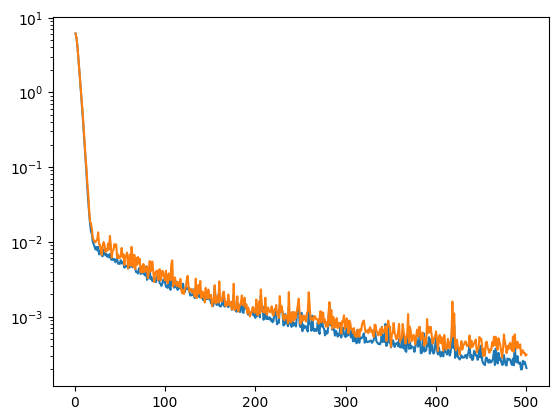

In [320]:
param_dict={'k':5,
            'learning_rate':0.001,
            'weight_decay':0.0001,
            'batch_size':64,
            'num_epochs':500}
result=k_fold(**param_dict)
result_dict={}
result_dict['param']=param_dict
result_dict['result']=result
result_list.append(result_dict)

In [259]:
for i in result_list:
    print(i['result'])

(0.00013419297465588897, 0.00022628275910392405)
(6.381380590028129e-05, 0.00017065096908481793)
(6.342656100362849e-05, 0.00016192397379199974)
(7.090350239498851e-05, 0.00015696228244147883)
(6.323121124296449e-05, 0.00016471944109071047)
(0.00015875250974204392, 0.00023397350742015988)
(6.630105126532726e-05, 0.00014898861409164965)


In [ ]:
param_dict={'k':5,
            'learning_rate':0.01,
            'weight_decay':0,
            'batch_size':64,
            'num_epochs':100}

In [277]:
k=5
learning_rate=0.005
weight_decay=0
batch_size=64
num_epochs=100
net=get_net()
train(net,train_features,train_label,None,None,num_epochs=100,learning_rate=learning_rate,weight_decay=0,batch_size=64)

([0.8716137409210205,
  0.11802928149700165,
  0.011176525615155697,
  0.0007930026622489095,
  0.0004255745152477175,
  0.0003594961017370224,
  0.0003105820796918124,
  0.0002769827260635793,
  0.0002517835528124124,
  0.0002318832412129268,
  0.00021650960843544453,
  0.000203089410206303,
  0.0001926920813275501,
  0.00018346699653193355,
  0.0001758766738930717,
  0.00016857357695698738,
  0.00016190602036658674,
  0.0001560261007398367,
  0.0001506590924691409,
  0.00014609014033339918,
  0.00014115124940872192,
  0.00013712001964449883,
  0.00013332258095033467,
  0.00013040914200246334,
  0.00012727045395877212,
  0.00012322489055804908,
  0.00012037358101224527,
  0.0001176907608169131,
  0.00011508452735142782,
  0.00011274617281742394,
  0.0001105812843888998,
  0.00010862649651244283,
  0.00010692809883039445,
  0.00010471203131601214,
  0.0001031194842653349,
  0.00010125980043085292,
  9.961497562471777e-05,
  9.848083573160693e-05,
  9.676429181126878e-05,
  9.5668037829

In [278]:
result=net(test_features).detach().reshape(1,-1)

In [279]:
result

tensor([[11.7001, 11.9284, 12.0939,  ..., 12.0336, 11.6345, 12.3146]])

In [280]:
torch.exp(result)

tensor([[120583.0781, 151511.4219, 178776.7344,  ..., 168313.6719,
         112922.6719, 222938.1406]])

In [281]:
test_data['SalePrice']=pd.Series(torch.exp(result)[0])

In [282]:
test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,120583.078125
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,151511.421875
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,178776.734375
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195561.828125
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,197157.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,81808.984375
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,82774.351562
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,168313.671875
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,112922.671875


In [283]:
test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,120583.078125
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,151511.421875
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,178776.734375
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195561.828125
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,197157.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,81808.984375
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,82774.351562
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,168313.671875
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,112922.671875


In [284]:
test_data[['Id','SalePrice']].to_csv('submission.csv',index=False)